In [1]:
import json
from haralyzer import HarParser, HarPage
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# Function to load HAR file
def load_har_file(filename):
    with open(filename, 'r') as f:
        har_parser = HarParser(json.loads(f.read()))
    return har_parser.pages[0]

In [3]:
# Load HAR files
nothrottle = load_har_file('IndiaPost_nothrottle.har')
config1 = load_har_file('IndiaPost_Config1.har')
config2 = load_har_file('IndiaPost_Config2.har')
config3 = load_har_file('IndiaPost_Config3.har')

In [4]:
# 1. Page Load Time
print("Page Load Times:")
print(f"No throttle: {nothrottle.page_load_time:.2f} ms")
print(f"Config 1: {config1.page_load_time:.2f} ms")
print(f"Config 2: {config2.page_load_time:.2f} ms")
print(f"Config 3: {config3.page_load_time:.2f} ms")

Page Load Times:
No throttle: 8318.21 ms
Config 1: 340439.70 ms
Config 2: 33032.94 ms
Config 3: 28945.86 ms


In [5]:

# 2. Request and Data Transfer Summary
def request_summary(page):
    total_requests = len(page.entries)
    total_size = sum((entry['response']['_transferSize']) for entry in page.entries)
    return total_requests, total_size

print("\nRequest and Data Transfer Summary:")
for name, page in [("No throttle", nothrottle), ("Config 1", config1), ("Config 2", config2), ("Config 3", config3)]:
    requests, size = request_summary(page)
    print(f"{name}: {requests} requests, {size/1024:.2f} KB transferred")


Request and Data Transfer Summary:
No throttle: 103 requests, 5402.99 KB transferred
Config 1: 103 requests, 5299.30 KB transferred
Config 2: 103 requests, 4721.36 KB transferred
Config 3: 103 requests, 3087.04 KB transferred


In [6]:
# 3. Content-Type Analysis
def content_type_analysis(page):
    content_types = {
        'text/html': {'count': 0, 'size': 0},
        'text/css': {'count': 0, 'size': 0},
        'application/javascript': {'count': 0, 'size': 0},
        'image': {'count': 0, 'size': 0}
    }
    for entry in page.entries:
        content_type = entry['response']['content']['mimeType']
        size = entry['response']['_transferSize']
        if content_type in content_types:
            content_types[content_type]['count'] += 1
            content_types[content_type]['size'] += size
        elif content_type.startswith('image/'):
            content_types['image']['count'] += 1
            content_types['image']['size'] += size
    return content_types

print("\nContent-Type Analysis:")
for name, page in [("No throttle", nothrottle), ("Config 1", config1), ("Config 2", config2), ("Config 3", config3)]:
    print(f"\n{name}:")
    for ctype, data in content_type_analysis(page).items():
        print(f"{ctype}: {data['count']} requests, {data['size']/1024:.2f} KB")


Content-Type Analysis:

No throttle:
text/html: 1 requests, 36.36 KB
text/css: 22 requests, 176.83 KB
application/javascript: 23 requests, 2628.70 KB
image: 47 requests, 2256.37 KB

Config 1:
text/html: 1 requests, 36.39 KB
text/css: 22 requests, 169.00 KB
application/javascript: 23 requests, 2534.19 KB
image: 47 requests, 2256.50 KB

Config 2:
text/html: 1 requests, 36.36 KB
text/css: 22 requests, 170.11 KB
application/javascript: 23 requests, 1968.75 KB
image: 47 requests, 2227.63 KB

Config 3:
text/html: 1 requests, 36.35 KB
text/css: 22 requests, 150.92 KB
application/javascript: 23 requests, 958.21 KB
image: 47 requests, 1613.15 KB


In [7]:
# 4 & 5. CDF of Download Times and Response Sizes
def plot_cdf(data, xlabel, ylabel, title):
    sorted_data = np.sort(data)
    yvals = np.arange(len(sorted_data))/float(len(sorted_data)-1)
    plt.plot(sorted_data, yvals)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

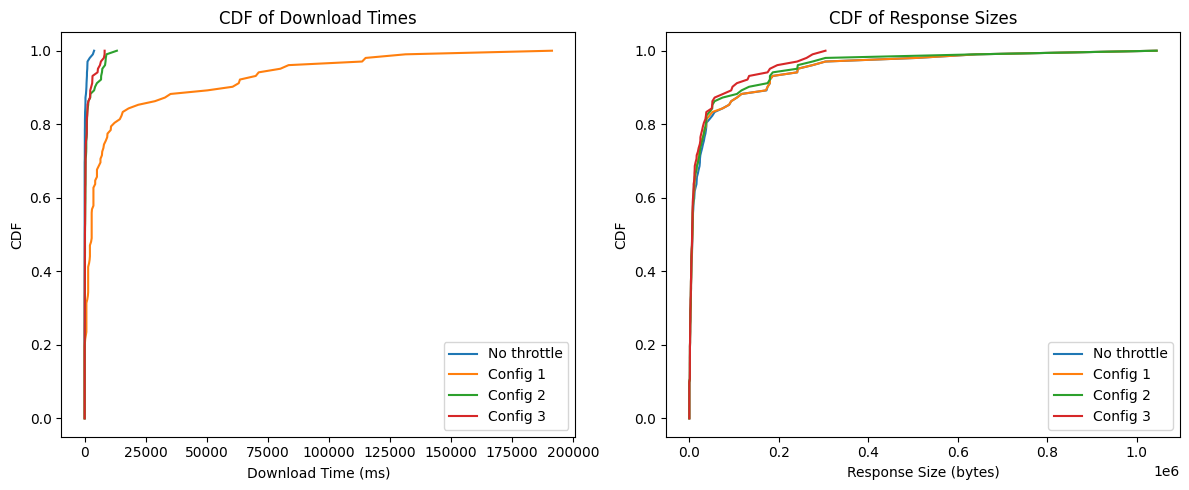

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for name, page in [("No throttle", nothrottle), ("Config 1", config1), ("Config 2", config2), ("Config 3", config3)]:
    download_times = [entry['timings']['receive'] for entry in page.entries]
    plot_cdf(download_times, 'Download Time (ms)', 'CDF', 'CDF of Download Times')
plt.legend(["No throttle", "Config 1", "Config 2", "Config 3"])

plt.subplot(1, 2, 2)
for name, page in [("No throttle", nothrottle), ("Config 1", config1), ("Config 2", config2), ("Config 3", config3)]:
    response_sizes = [entry['response']['_transferSize'] for entry in page.entries]
    plot_cdf(response_sizes, 'Response Size (bytes)', 'CDF', 'CDF of Response Sizes')
plt.legend(["No throttle", "Config 1", "Config 2", "Config 3"])

plt.tight_layout()
plt.show()

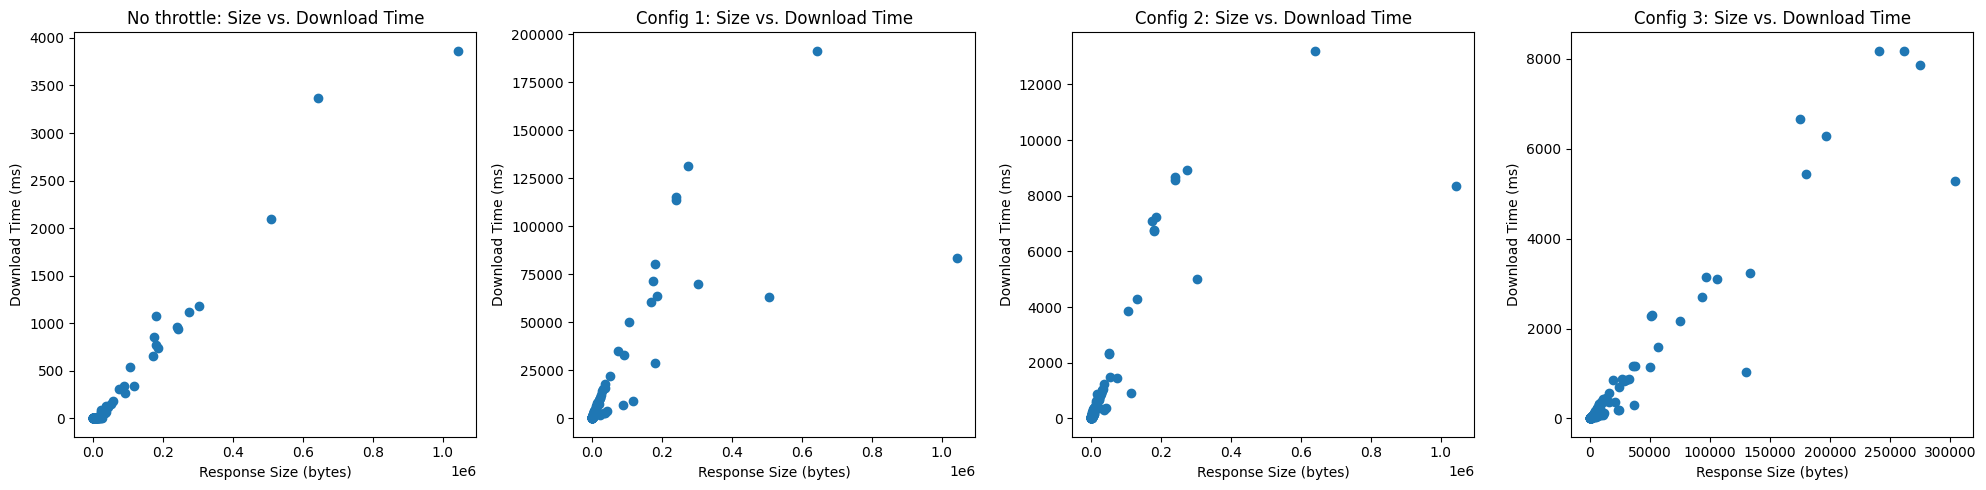

In [9]:
# 6. Scatter Plot: Size vs. Download Time
plt.figure(figsize=(20, 5))
for i, (name, page) in enumerate([("No throttle", nothrottle), ("Config 1", config1), ("Config 2", config2), ("Config 3", config3)]):
    plt.subplot(1, 4, i+1)
    sizes = [entry['response']['_transferSize'] for entry in page.entries]
    times = [entry['timings']['receive'] for entry in page.entries]
    plt.scatter(sizes, times)
    plt.xlabel('Response Size (bytes)')
    plt.ylabel('Download Time (ms)')
    plt.title(f'{name}: Size vs. Download Time')

plt.tight_layout()
plt.show()